In [1]:
# Import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import random
import torch
from concurrent.futures import ThreadPoolExecutor
import torch.nn as nn
import torch.optim as optim

In [2]:
"""
Seed for reproducibility. This ensures that the training and
testing process produce the same results when they are rerun.
""" 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(2024)

In [3]:
# Load csv files
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [4]:
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


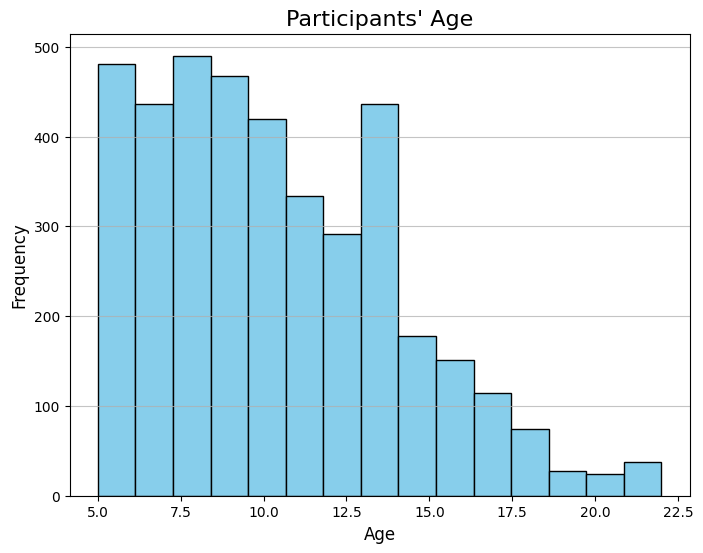

In [5]:
# Age distribution
plt.figure(figsize=(8, 6))
plt.hist(df_train['Basic_Demos-Age'], bins=15, color='skyblue', edgecolor='black')
plt.title('Participants\' Age', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

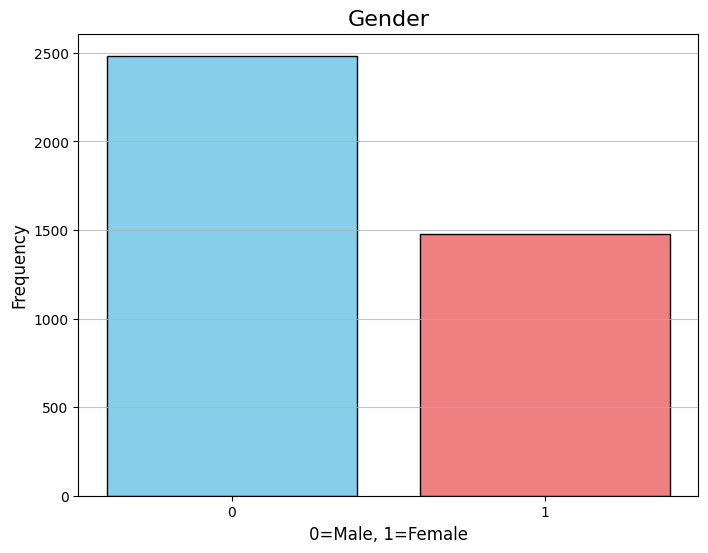

In [6]:
# Gender distribution
plt.figure(figsize=(8, 6))
gender_counts = df_train['Basic_Demos-Sex'].value_counts()
plt.bar(gender_counts.index.astype(str), gender_counts.values, color=['skyblue', 'lightcoral'], edgecolor='black')
plt.title('Gender', fontsize=16)
plt.xlabel('0=Male, 1=Female', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

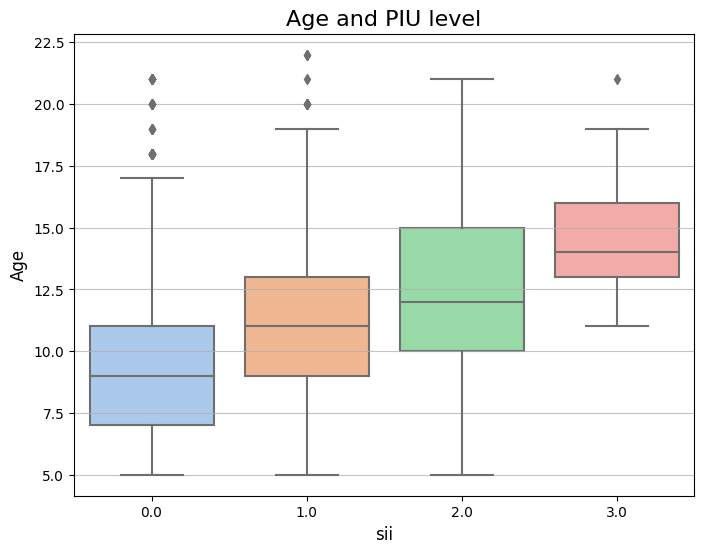

In [7]:
# Plot the relation between ages and problematic internet use (PIU) level
plt.figure(figsize=(8, 6))
sns.boxplot(x='sii', y='Basic_Demos-Age', data=df_train, palette='pastel')
plt.title('Age and PIU level', fontsize=16)
plt.xlabel('sii', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

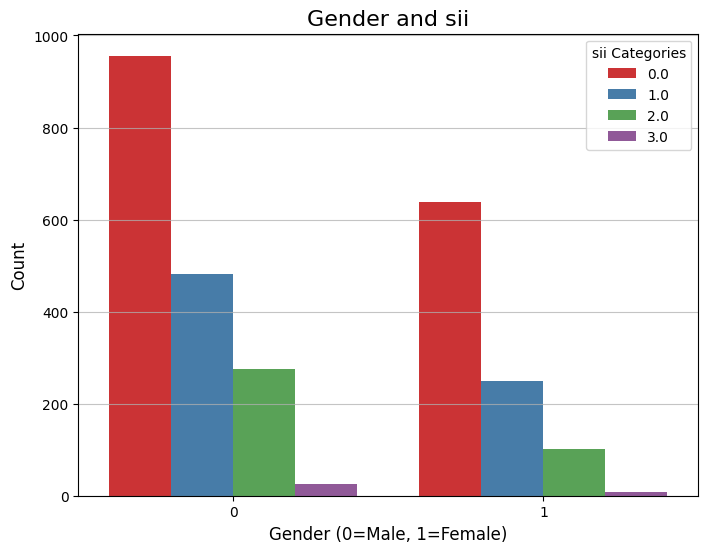

In [8]:
# Plot the relation between genders and PIU level
plt.figure(figsize=(8, 6))
grouped_data = df_train.groupby(['Basic_Demos-Sex', 'sii']).size().reset_index(name='Count')
sns.barplot(x='Basic_Demos-Sex', y='Count', hue='sii', data=grouped_data, palette='Set1')
plt.title('Gender and sii', fontsize=16)
plt.xlabel('Gender (0=Male, 1=Female)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='sii Categories')
plt.grid(axis='y', alpha=0.75)
plt.show()

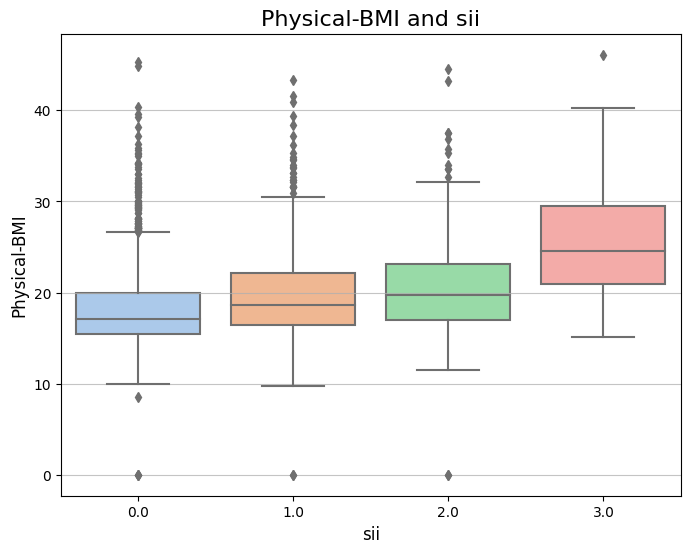

In [9]:
# Plot the relation between Physical-BMI and sii
plt.figure(figsize=(8, 6))
sns.boxplot(x='sii', y='Physical-BMI', data=df_train, palette='pastel')
plt.title('Physical-BMI and sii', fontsize=16)
plt.xlabel('sii', fontsize=12)
plt.ylabel('Physical-BMI', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [10]:
# Remove samples with NaN values in 'sii' field
df_train = df_train.drop(df_train.loc[df_train['sii'].isnull()].index, errors='ignore')
df_train = df_train.reset_index(drop=True)
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,...,2.0,2.0,1.0,22.0,Fall,41.0,58.0,Fall,2.0,0.0
2732,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,...,3.0,3.0,0.0,33.0,Summer,48.0,67.0,Summer,0.0,1.0
2733,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
2734,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0


In [11]:
# Remove features with the percentage of missing values > 40%
total = df_train.isnull().sum().sort_values(ascending=False)
proportion = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, proportion], axis=1, keys=['Total', 'Percentage'])
missing_data[missing_data['Percentage'] > 0.4]

,Total,Percentage
PAQ_A-PAQ_A_Total,2373,0.867325
PAQ_A-Season,2373,0.867325
Physical-Waist_Circumference,2253,0.823465
Fitness_Endurance-Time_Sec,2008,0.733918
Fitness_Endurance-Time_Mins,2008,0.733918
Fitness_Endurance-Max_Stage,2005,0.732822
FGC-FGC_GSD_Zone,1872,0.684211
FGC-FGC_GSND_Zone,1872,0.684211
FGC-FGC_GSD,1865,0.681652
FGC-FGC_GSND,1864,0.681287


In [12]:
df_train = df_train.drop((missing_data[missing_data['Percentage'] > 0.4]).index, axis=1, errors='ignore')
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,...,2.0,2.0,1.0,22.0,Fall,41.0,58.0,Fall,2.0,0.0
2732,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,...,3.0,3.0,0.0,33.0,Summer,48.0,67.0,Summer,0.0,1.0
2733,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
2734,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0


In [13]:
# Impute numerical data by KNNImputer
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
df_train[num_cols] = knn_imputer.fit_transform(df_train[num_cols])


# Impute categorical data by SimpleImputer
from sklearn.impute import SimpleImputer
cat_cols = df_train.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[cat_cols] = cat_imputer.fit_transform(df_train[cat_cols])
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5.0,0.0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,Spring,42.8,60.0,Fall,3.0,2.0
1,000fd460,Summer,9.0,0.0,Spring,63.4,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10.0,1.0,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9.0,0.0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,001f3379,Spring,13.0,1.0,Winter,50.0,Summer,22.279952,59.5,112.2,...,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,Fall,8.0,0.0,Spring,66.0,Fall,17.139810,52.5,67.2,...,2.0,2.0,1.0,22.0,Fall,41.0,58.0,Fall,2.0,0.0
2732,ff759544,Summer,7.0,1.0,Spring,60.2,Summer,13.927006,48.5,46.6,...,3.0,3.0,0.0,33.0,Summer,48.0,67.0,Summer,0.0,1.0
2733,ff8a2de4,Fall,13.0,0.0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
2734,ffcd4dbd,Fall,11.0,0.0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0


In [14]:
# Season mapping
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
train_season_cols = [col for col in df_train.columns if 'Season' in col]
for col in train_season_cols:
    df_train[col] = df_train[col].replace(season_mapping).astype('int')
df_train

/tmp/ipykernel_17/1313792880.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col] = df_train[col].replace(season_mapping).astype('int')
/tmp/ipykernel_17/1313792880.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col] = df_train[col].replace(season_mapping).astype('int')
/tmp/ipykernel_17/1313792880.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the fu

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,3,5.0,0.0,4,51.0,3,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,1,42.8,60.0,3,3.0,2.0
1,000fd460,2,9.0,0.0,1,63.4,3,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,3,46.0,64.0,2,0.0,0.0
2,00105258,2,10.0,1.0,3,71.0,3,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,3,38.0,54.0,2,2.0,0.0
3,00115b9f,4,9.0,0.0,3,71.0,2,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,2,31.0,45.0,4,0.0,1.0
4,001f3379,1,13.0,1.0,4,50.0,2,22.279952,59.5,112.2,...,1.0,2.0,1.0,34.0,2,40.0,56.0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,3,8.0,0.0,1,66.0,3,17.139810,52.5,67.2,...,2.0,2.0,1.0,22.0,3,41.0,58.0,3,2.0,0.0
2732,ff759544,2,7.0,1.0,1,60.2,2,13.927006,48.5,46.6,...,3.0,3.0,0.0,33.0,2,48.0,67.0,2,0.0,1.0
2733,ff8a2de4,3,13.0,0.0,1,60.0,3,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,4,35.0,50.0,3,1.0,1.0
2734,ffcd4dbd,3,11.0,0.0,1,68.0,4,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,4,56.0,77.0,3,0.0,1.0


In [15]:
# drop all "PCIAT" features because they represent the subjective opinions of parents.
pciat_columns = [col for col in df_train.columns if 'PCIAT' in col]
df_train = df_train.drop(pciat_columns, axis=1, errors='ignore')
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,3,5.0,0.0,4,51.0,3,16.877316,46.0,50.8,...,8.89536,38.9177,19.54130,32.69090,1,42.8,60.0,3,3.0,2.0
1,000fd460,2,9.0,0.0,1,63.4,3,14.035590,48.0,46.0,...,14.97400,39.4497,15.41070,27.05520,3,46.0,64.0,2,0.0,0.0
2,00105258,2,10.0,1.0,3,71.0,3,16.648696,56.5,75.6,...,14.08406,53.3641,25.41684,43.06968,3,38.0,54.0,2,2.0,0.0
3,00115b9f,4,9.0,0.0,3,71.0,2,18.292347,56.0,81.6,...,16.77900,58.9338,26.47980,45.99660,2,31.0,45.0,4,0.0,1.0
4,001f3379,1,13.0,1.0,4,50.0,2,22.279952,59.5,112.2,...,20.90200,79.6982,35.38040,63.12650,2,40.0,56.0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,3,8.0,0.0,1,66.0,3,17.139810,52.5,67.2,...,15.81500,49.3301,20.26450,36.71810,3,41.0,58.0,3,2.0,0.0
2732,ff759544,2,7.0,1.0,1,60.2,2,13.927006,48.5,46.6,...,15.14000,42.8185,18.09370,30.04530,2,48.0,67.0,2,0.0,1.0
2733,ff8a2de4,3,13.0,0.0,1,60.0,3,16.362460,59.5,82.4,...,17.97970,66.2889,29.77900,52.83200,4,35.0,50.0,3,1.0,1.0
2734,ffcd4dbd,3,11.0,0.0,1,68.0,4,21.441500,60.0,109.8,...,21.34030,71.3903,28.77920,54.46300,4,56.0,77.0,3,0.0,1.0


In [16]:
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    
    return df

df_train = feature_engineering(df_train)

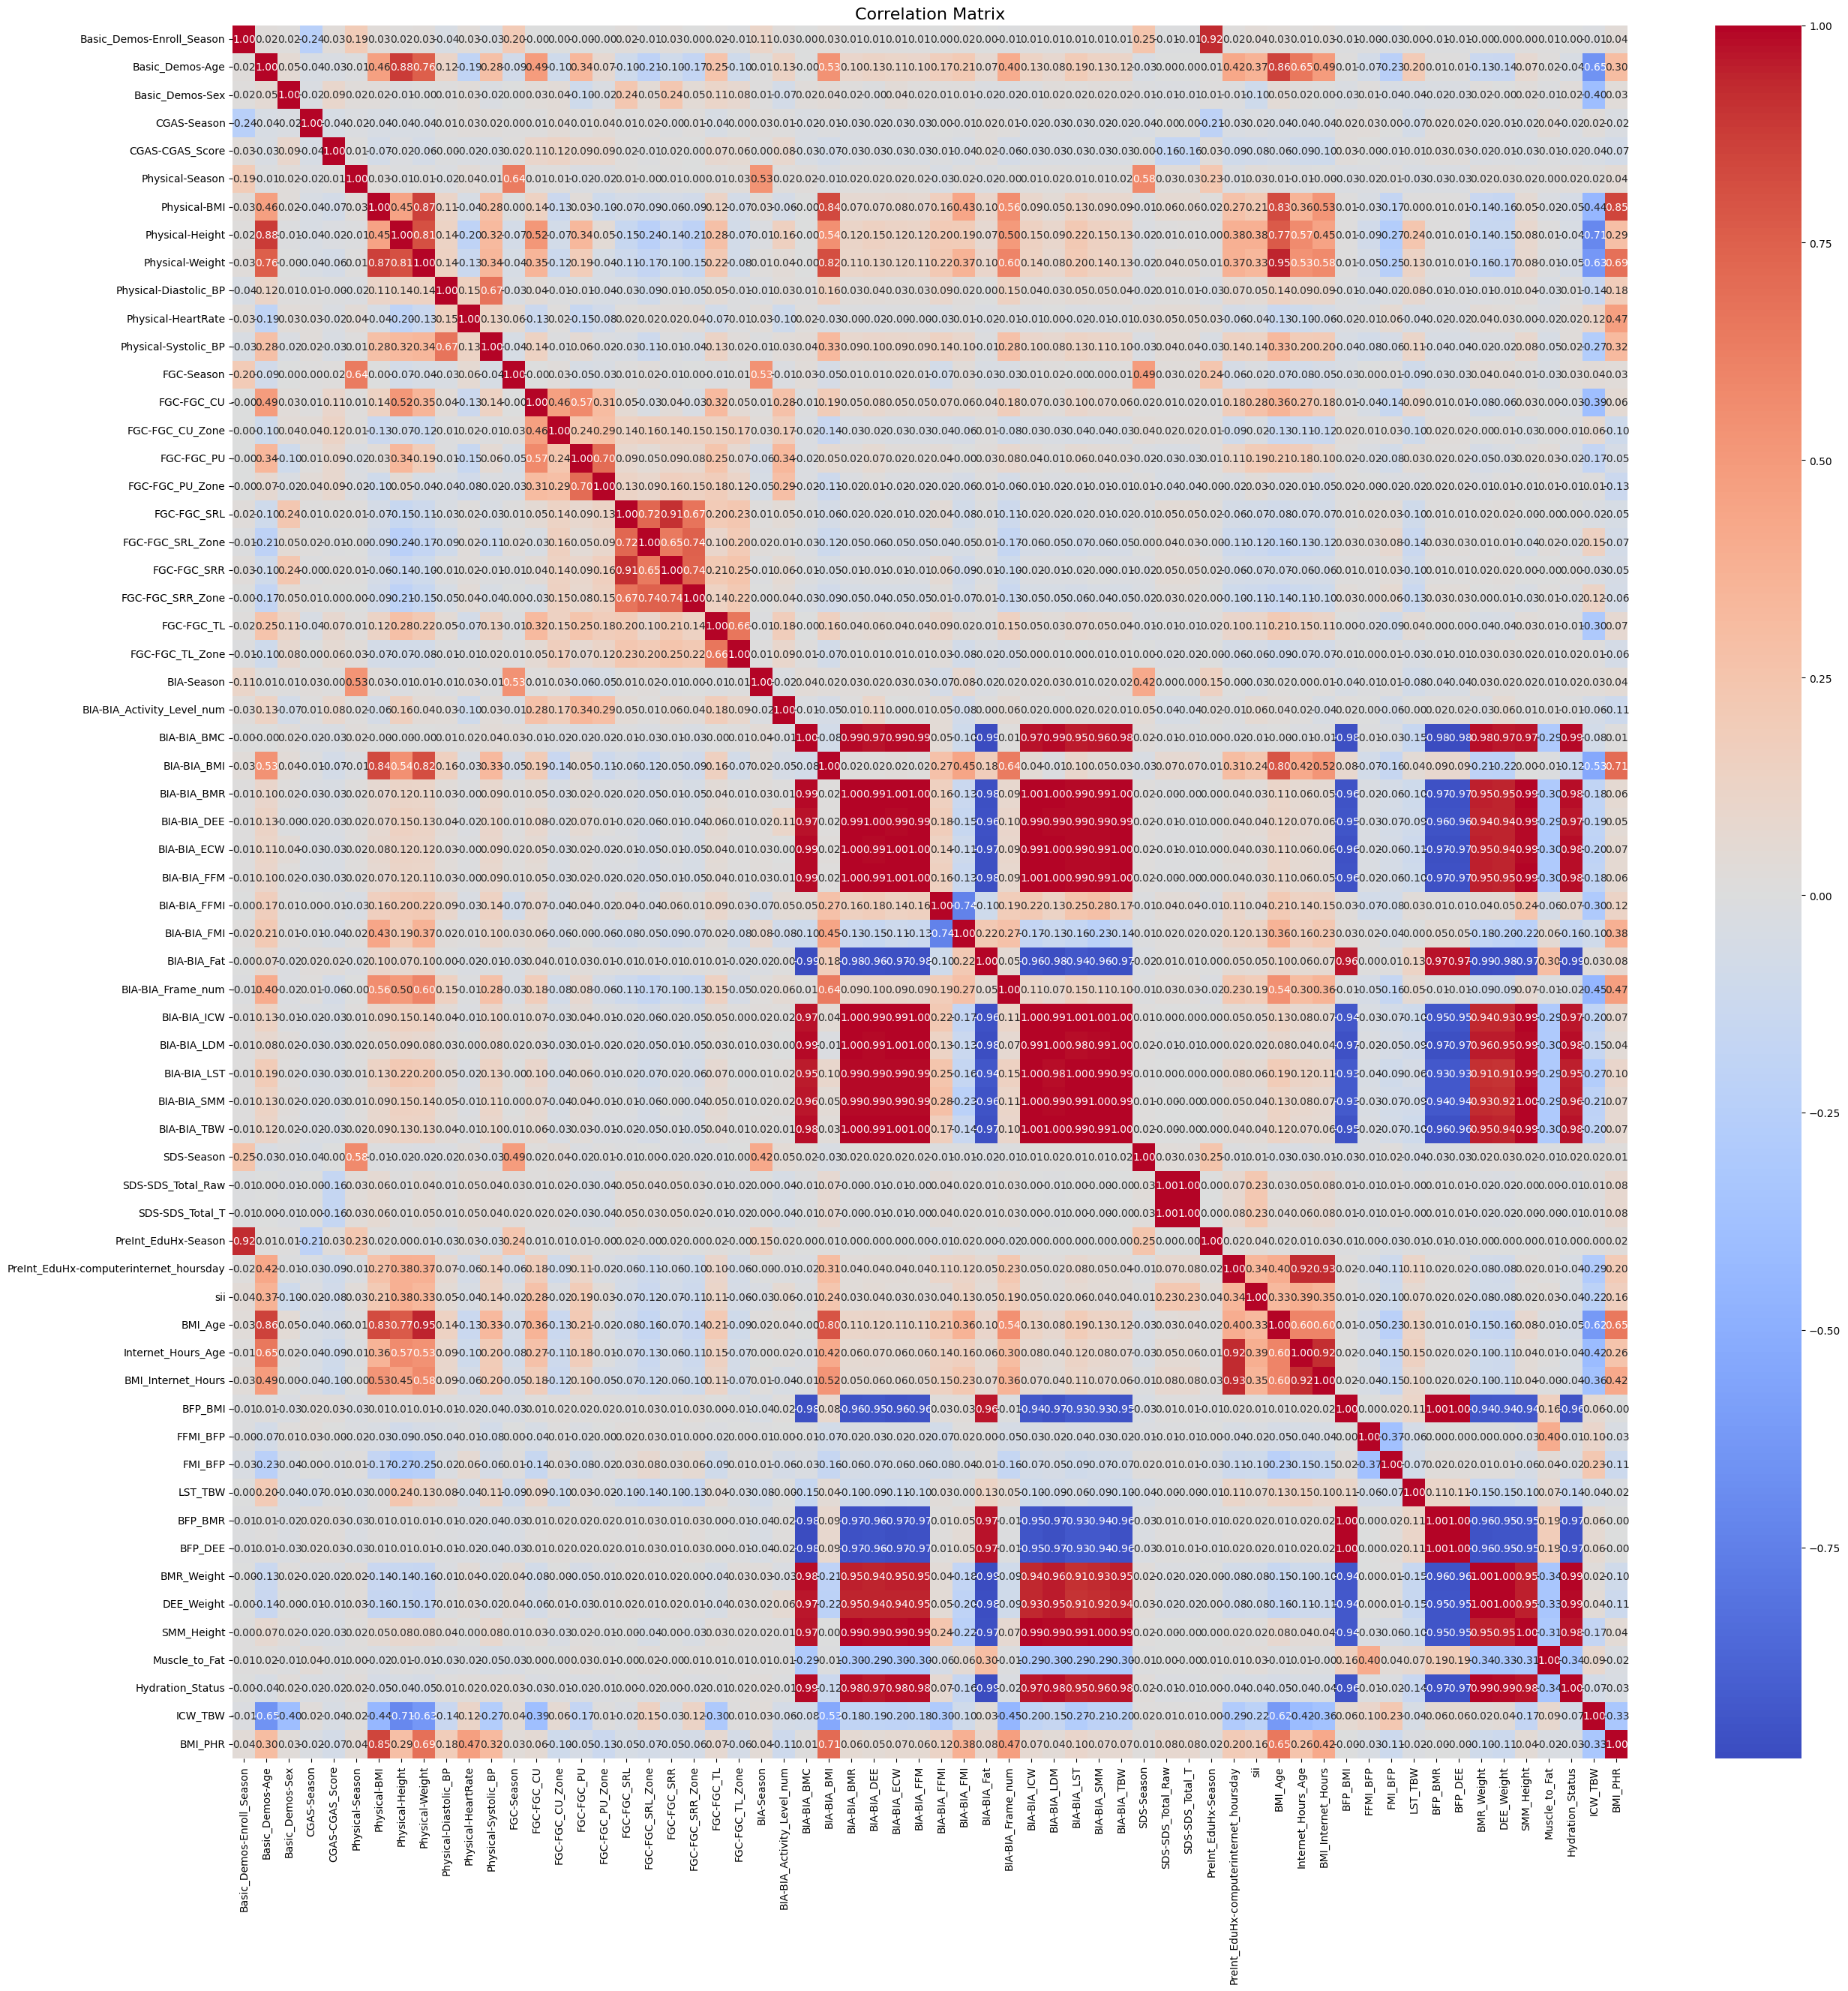

In [17]:
# Create a correlation matrix to show correlations between features in the data.
df_train_no_id = df_train.drop(['id'], axis=1, errors='ignore')
corrmat = df_train_no_id.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corrmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [18]:
# drop features that cause multicollinearity
multicollinerity = set()
for i in range(len(corrmat.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.8:
            multicollinerity.add(corrmat.columns[i])
multicollinerity.discard('sii')
df_train = df_train.drop(multicollinerity, axis=1, errors='ignore')
print(f"Removed columns: {multicollinerity}")
df_train

Removed columns: {'Physical-Height', 'BIA-BIA_LDM', 'SDS-SDS_Total_T', 'DEE_Weight', 'BIA-BIA_ICW', 'BMI_Age', 'SMM_Height', 'Hydration_Status', 'BMI_PHR', 'BIA-BIA_ECW', 'BFP_BMR', 'PreInt_EduHx-Season', 'BIA-BIA_FFM', 'BFP_BMI', 'BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_Fat', 'BIA-BIA_LST', 'BIA-BIA_DEE', 'Internet_Hours_Age', 'FGC-FGC_SRR', 'BIA-BIA_SMM', 'BMI_Internet_Hours', 'Physical-Weight', 'BIA-BIA_BMI', 'BFP_DEE', 'BMR_Weight'}


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_Frame_num,SDS-Season,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,sii,FFMI_BFP,FMI_BFP,LST_TBW,Muscle_to_Fat,ICW_TBW
0,00008ff9,3,5.0,0.0,4,51.0,3,16.877316,66.8,79.4,...,1.0,1,42.8,3.0,2.0,1.499679,0.332267,1.190475,6.383063,0.747453
1,000fd460,2,9.0,0.0,1,63.4,3,14.035590,75.0,70.0,...,1.0,3,46.0,0.0,0.0,3.229888,0.305154,1.458119,12.718037,0.777492
2,00105258,2,10.0,1.0,3,71.0,3,16.648696,65.0,94.0,...,1.4,3,38.0,2.0,0.0,0.900023,0.247908,1.239018,6.535989,0.646953
3,00115b9f,4,9.0,0.0,3,71.0,2,18.292347,60.0,97.0,...,2.0,2,31.0,0.0,1.0,0.747651,0.224196,1.281264,6.274343,0.661008
4,001f3379,1,13.0,1.0,4,50.0,2,22.279952,60.0,73.0,...,2.0,2,40.0,0.0,1.0,0.245510,0.198595,1.262516,2.621003,0.521399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,3,8.0,0.0,1,66.0,3,17.139810,60.0,65.0,...,1.0,3,41.0,2.0,0.0,0.913649,0.255085,1.343482,5.416433,0.700249
2732,ff759544,2,7.0,1.0,1,60.2,2,13.927006,65.0,75.0,...,1.0,2,48.0,0.0,1.0,9.352866,0.292827,1.425131,43.676843,0.667565
2733,ff8a2de4,3,13.0,0.0,1,60.0,3,16.362460,71.0,70.0,...,1.0,4,35.0,1.0,1.0,1.213543,0.198595,1.254711,12.939628,0.631642
2734,ffcd4dbd,3,11.0,0.0,1,68.0,4,21.441500,79.0,99.0,...,2.0,4,56.0,0.0,1.0,0.435463,0.195299,1.310804,4.334530,0.623919


In [19]:
# Function to load and process parquet files
def process_parquet(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

# Optimize loading time series
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_parquet(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3), nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2), nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2), nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3), nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Optimize Autoencoder Training Function
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    return df_encoded

In [20]:
# Load parquet files
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


In [21]:
# Use AutoEncoder to reduce dimensionality of the data
# Then merge the parquet data into the csv data
train_ts_no_id = train_ts.drop('id', axis=1)
test_ts_no_id = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(train_ts_no_id, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(test_ts_no_id, encoding_dim=60, epochs=100, batch_size=32)

train_ts_encoded["id"] = train_ts["id"]
test_ts_encoded['id'] = test_ts["id"]

df_train = pd.merge(df_train, train_ts_encoded, how="left", on='id')
df_test = pd.merge(df_test, test_ts_encoded, how="left", on='id')

Epoch [10/100], Loss: 1.6378
Epoch [20/100], Loss: 1.5450
Epoch [30/100], Loss: 1.5127
Epoch [40/100], Loss: 1.5011
Epoch [50/100], Loss: 1.5013
Epoch [60/100], Loss: 1.5026
Epoch [70/100], Loss: 1.4933
Epoch [80/100], Loss: 1.4747
Epoch [90/100], Loss: 1.4714
Epoch [100/100], Loss: 1.4555
Epoch [10/100], Loss: 1.0070
Epoch [20/100], Loss: 0.5783
Epoch [30/100], Loss: 0.4271
Epoch [40/100], Loss: 0.4271
Epoch [50/100], Loss: 0.4271
Epoch [60/100], Loss: 0.4271
Epoch [70/100], Loss: 0.4271
Epoch [80/100], Loss: 0.4271
Epoch [90/100], Loss: 0.4271
Epoch [100/100], Loss: 0.4271


In [22]:
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,3,5.0,0.0,4,51.0,3,16.877316,66.8,79.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,2,9.0,0.0,1,63.4,3,14.035590,75.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,2,10.0,1.0,3,71.0,3,16.648696,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,4,9.0,0.0,3,71.0,2,18.292347,60.0,97.0,...,0.590492,1.065462,1.234016,0.000000,0.0,3.349180,1.690656,2.483185,5.593308,1.066349
4,001f3379,1,13.0,1.0,4,50.0,2,22.279952,60.0,73.0,...,1.449124,2.364651,0.000000,0.000000,0.0,0.000000,0.000000,0.552680,0.000000,3.285048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,3,8.0,0.0,1,66.0,3,17.139810,60.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2732,ff759544,2,7.0,1.0,1,60.2,2,13.927006,65.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2733,ff8a2de4,3,13.0,0.0,1,60.0,3,16.362460,71.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2734,ffcd4dbd,3,11.0,0.0,1,68.0,4,21.441500,79.0,99.0,...,0.000000,2.595756,0.397466,2.183397,0.0,0.472042,0.393381,0.000000,0.000000,1.932896


In [23]:
knn_imputer = KNNImputer(n_neighbors=5)
num_cols = df_train.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
df_train[num_cols] = knn_imputer.fit_transform(df_train[num_cols])
df_train = df_train.dropna(thresh=10, axis=0)
df_train

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,3.0,5.0,0.0,4.0,51.0,3.0,16.877316,66.8,79.4,...,1.536376,1.000296,1.645361,3.988511,0.0,0.772910,2.273083,0.202293,0.575473,3.865821
1,000fd460,2.0,9.0,0.0,1.0,63.4,3.0,14.035590,75.0,70.0,...,0.296517,4.051226,5.255536,2.595047,0.0,2.151332,1.711746,1.340053,1.496128,0.817505
2,00105258,2.0,10.0,1.0,3.0,71.0,3.0,16.648696,65.0,94.0,...,1.497976,2.621967,2.506557,0.764647,0.0,2.088820,1.696295,0.962041,1.407303,1.058875
3,00115b9f,4.0,9.0,0.0,3.0,71.0,2.0,18.292347,60.0,97.0,...,0.590492,1.065462,1.234016,0.000000,0.0,3.349180,1.690656,2.483185,5.593308,1.066349
4,001f3379,1.0,13.0,1.0,4.0,50.0,2.0,22.279952,60.0,73.0,...,1.449124,2.364651,0.000000,0.000000,0.0,0.000000,0.000000,0.552680,0.000000,3.285048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ff6c2bb8,3.0,8.0,0.0,1.0,66.0,3.0,17.139810,60.0,65.0,...,2.656855,2.632014,3.330938,2.099436,0.0,0.602306,0.647599,2.134567,3.775015,1.770483
2732,ff759544,2.0,7.0,1.0,1.0,60.2,2.0,13.927006,65.0,75.0,...,0.890804,1.723763,2.822254,4.996293,0.0,1.247752,0.486773,1.632302,2.102363,1.248664
2733,ff8a2de4,3.0,13.0,0.0,1.0,60.0,3.0,16.362460,71.0,70.0,...,2.284307,1.675942,2.245479,3.226738,0.0,1.230442,0.139872,1.258305,1.719642,2.906299
2734,ffcd4dbd,3.0,11.0,0.0,1.0,68.0,4.0,21.441500,79.0,99.0,...,0.000000,2.595756,0.397466,2.183397,0.0,0.472042,0.393381,0.000000,0.000000,1.932896


In [24]:
df_test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,3.087122,9.608292,0.000000,0.120096,0.0,9.299348,6.812585,0.000000,0.000000,3.360213
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,6.256849,0.000000,11.235291,0.000000,0.0,4.316035,3.154848,3.933196,8.849051,2.365496
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Feature engineering for test data
df_test = feature_engineering(df_test)
df_test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1564.977430
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,1.281264,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008,1774.357653
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,1.262516,90468.027355,135701.701175,11.862478,17.793672,0.594629,2.621003,0.562625,0.521399,1626.436495
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,1.259274,24254.018580,38806.515140,13.426241,21.482033,0.476285,5.278294,0.558169,0.654233,1631.843107
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,1.265839,19172.581896,30676.066044,14.014727,22.423515,0.485536,8.840947,0.599486,0.565344,1517.515782
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# We keep df_test's features that are the same with df_train's features except the 'sii' feature
cols_to_keep = df_train.columns.drop('sii')
df_test = df_test[cols_to_keep]
df_test

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,75.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,60.0,97.0,...,3.087122,9.608292,0.000000,0.120096,0.0,9.299348,6.812585,0.000000,0.000000,3.360213
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,60.0,73.0,...,6.256849,0.000000,11.235291,0.000000,0.0,4.316035,3.154848,3.933196,8.849051,2.365496
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,123.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,71.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
num_cols = df_test.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
df_test[num_cols] = knn_imputer.fit_transform(df_test[num_cols])

# SimpleImputer
simple_imputer = SimpleImputer(strategy='most_frequent')
cat_cols = df_test.select_dtypes(include=['object']).columns
df_test[cat_cols] = simple_imputer.fit_transform(df_test[cat_cols])
df_test

/tmp/ipykernel_17/418021542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[num_cols] = knn_imputer.fit_transform(df_test[num_cols])
/tmp/ipykernel_17/418021542.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[cat_cols] = simple_imputer.fit_transform(df_test[cat_cols])


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,Fall,5.0,0.0,Winter,51.0,Fall,16.877316,78.0,83.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
1,000fd460,Summer,9.0,0.0,Summer,63.6,Fall,14.035590,75.0,70.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
2,00105258,Summer,10.0,1.0,Fall,71.0,Fall,16.648696,65.0,94.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
3,00115b9f,Winter,9.0,0.0,Fall,71.0,Summer,18.292347,60.0,97.0,...,3.087122,9.608292,0.000000,0.120096,0.0,9.299348,6.812585,0.000000,0.000000,3.360213
4,0016bb22,Spring,18.0,1.0,Summer,61.8,Fall,19.131514,63.2,79.6,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
5,001f3379,Spring,13.0,1.0,Winter,50.0,Summer,22.279952,60.0,73.0,...,6.256849,0.000000,11.235291,0.000000,0.0,4.316035,3.154848,3.933196,8.849051,2.365496
6,0038ba98,Fall,10.0,0.0,Summer,59.6,Fall,19.660760,123.0,83.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
7,0068a485,Fall,10.0,1.0,Summer,65.6,Fall,16.861286,71.0,90.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
8,0069fbed,Summer,15.0,0.0,Summer,61.8,Spring,18.482622,74.8,80.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
9,0083e397,Summer,19.0,1.0,Summer,61.8,Fall,19.131514,63.2,79.6,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854


In [28]:
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
season_cols = [col for col in df_test.columns if 'Season' in col]
for col in season_cols:
    df_test[col] = df_test[col].replace(season_mapping).astype('int')
df_test

/tmp/ipykernel_17/983320084.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[col] = df_test[col].replace(season_mapping).astype('int')
/tmp/ipykernel_17/983320084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test[col].replace(season_mapping).astype('int')
/tmp/ipykernel_17/983320084.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to t

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,...,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,00008ff9,3,5.0,0.0,4,51.0,3,16.877316,78.0,83.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
1,000fd460,2,9.0,0.0,2,63.6,3,14.035590,75.0,70.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
2,00105258,2,10.0,1.0,3,71.0,3,16.648696,65.0,94.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
3,00115b9f,4,9.0,0.0,3,71.0,2,18.292347,60.0,97.0,...,3.087122,9.608292,0.000000,0.120096,0.0,9.299348,6.812585,0.000000,0.000000,3.360213
4,0016bb22,1,18.0,1.0,2,61.8,3,19.131514,63.2,79.6,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
5,001f3379,1,13.0,1.0,4,50.0,2,22.279952,60.0,73.0,...,6.256849,0.000000,11.235291,0.000000,0.0,4.316035,3.154848,3.933196,8.849051,2.365496
6,0038ba98,3,10.0,0.0,2,59.6,3,19.660760,123.0,83.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
7,0068a485,3,10.0,1.0,2,65.6,3,16.861286,71.0,90.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
8,0069fbed,2,15.0,0.0,2,61.8,1,18.482622,74.8,80.0,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854
9,0083e397,2,19.0,1.0,2,61.8,3,19.131514,63.2,79.6,...,4.671986,4.804146,5.617646,0.060048,0.0,6.807692,4.983717,1.966598,4.424526,2.862854


In [29]:
def threshold_rounder(oof_non_rounded, thresholds):
    """
    Convert unrounded values ​​to rounded values ​​based on thresholds.
    """
    return np.digitize(oof_non_rounded, thresholds, right=True)

def quadratic_weighted_kappa(y_true, y_pred): 
    """
    Calculate the quadratic weighted kappa between y_true and y_pred.
    """
    rounded_y_true = threshold_rounder(y_true, [0.5, 1.5, 2.5])
    rounded_y_pred = threshold_rounder(y_pred, [0.5, 1.5, 2.5])
    return cohen_kappa_score(rounded_y_true, rounded_y_pred, weights='quadratic')

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluate predictions by optimizing quadratic weighted kappa.
    """
    rounded_y_true = threshold_rounder(y_true, thresholds)
    rounded_p = threshold_rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(rounded_y_true, rounded_p)

def preprocess_data(train_data, test_data, target_column):
    """
    Data preprocessing: prepare training and testing data.
    """
    X = train_data.drop(columns=[target_column, 'id'])
    y = train_data[target_column]
    test_data_dropped = test_data.drop(columns=['id'])

    return X, y, test_data_dropped, test_data['id']

def train_and_predict(X, y, test_data_dropped, models, n_splits=5, random_state=42):
    """
    Train the models and predict on the test set.
    """
    SKF = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_non_rounded = np.zeros(len(y), dtype=float)
    test_preds = np.zeros((len(test_data_dropped), n_splits))
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            oof_non_rounded[test_idx] += y_val_pred / len(models)
            test_preds[:, fold] += model.predict(test_data_dropped) / len(models)
    
    return oof_non_rounded, test_preds

def optimize_threshold(y_true, oof_non_rounded):
    """
    Optimize threshold to improve QWK score.
    """
    KappaOptimizer = minimize(
        evaluate_predictions, x0=[0.5, 1.5, 2.5],
        args=(y_true, oof_non_rounded), method='Nelder-Mead'
    )
    assert KappaOptimizer.success, "Optimization did not converge."
    return KappaOptimizer.x

def create_submission(test_ids, target_column, tpTuned):
    """
    Create submission file from final prediction results.
    """
    submission = pd.DataFrame({
        'id': test_ids,
        target_column: tpTuned
    })
    return submission

def TrainML(train_data, test_data, target_column, n_splits=5, random_state=42):
    """
    Main function to train the model, optimize the threshold and create submission.
    """
    X, y, test_data_dropped, test_ids = preprocess_data(train_data, test_data, target_column)
    
    models = {
        'xgboost': XGBRegressor(
            learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8,
            colsample_bytree=0.8, reg_alpha=1, reg_lambda=5, random_state=random_state
        ),
        'gboost': GradientBoostingRegressor(
            learning_rate=0.05, max_depth=6, n_estimators=200, random_state=random_state
        ),
        'catboost': CatBoostRegressor(
            learning_rate=0.05, depth=6, iterations=200, random_state=random_state, verbose=0
        )
    }

    oof_non_rounded, test_preds = train_and_predict(X, y, test_data_dropped, models, n_splits, random_state)

    optimal_threshold = optimize_threshold(y, oof_non_rounded)
    
    oof_tuned = threshold_rounder(oof_non_rounded, optimal_threshold)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")
    
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_rounder(tpm, optimal_threshold)

    # Tạo submission
    submission = create_submission(test_ids, target_column, tpTuned)

    return submission

In [30]:
submission = TrainML(df_train, df_test, target_column="sii")

Training Folds: 100%|██████████| 5/5 [01:58<00:00, 23.75s/it]

----> || Optimized QWK SCORE :: 0.529


In [31]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


In [32]:
submission.to_csv('submission.csv', index=False)